# Linear inverse solutions in NumPy

Reproducing Mauricio Sacchi's [GEOPH 431 and 531 tutorial on linear inversion](https://www.ualberta.ca/~msacchi/GEOPH431_531/linear_intro.pdf), which was written in MATLAB. Mauricio's version is also recorded at SubSurfWiki on the [Linear inversion chrestomathy](http://www.subsurfwiki.org/wiki/Linear_inversion_chrestomathy) page.

**NB For the `@` notation to work (matrix mulitplication) you need Python 3.5 and Numpy 1.11.**

First, the usual preliminaries.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

## Define the problem

In [2]:
# Define model m
M = 50
m = np.zeros((M, 1))
m[10:15,:] = 1.0
m[15:27,:] = -0.3
m[27:35,:] = 2.1

In [3]:
# Discrete kernel G
N = 20
L = 100
alpha = 0.8

x = np.arange(0, M, 1) * L/(M-1)
dx = L/(M-1)
r = np.arange(0, N, 1) * L/(N-1)

In [4]:
G = np.zeros((N, M))
for j in range(M):
    for k in range(N):
        G[k,j] = dx * np.exp(-alpha * np.abs(r[k] - x[j])**2)

## Noise-free: minimum norm

In [7]:
# Compute data
d = G.dot(m)

# Or, in Python 3.5
d = G @ m

In [12]:
# Minimum norm solution in Python < 3.5
m_est = G.T.dot(la.inv(G.dot(G.T)).dot(d))
d_pred = G.dot(m_est)

# Or, in Python 3.5
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

In [14]:
def plot_all(m, d, m_est, d_pred):
    fig = plt.figure(figsize=(10,6))

    ax0 = fig.add_subplot(2,2,1)
    ax0.plot(m)
    ax0.set_title("$\mathrm{Model}\ m$")

    ax1 = fig.add_subplot(2,2,2)
    ax1.plot(d, '*')
    ax1.set_title("$\mathrm{Data}\ d$")

    ax2 = fig.add_subplot(2,2,3)
    ax2.plot(m_est)
    ax2.set_title("$\mathrm{Estimated\ model}\ m_\mathrm{est}$")

    ax3 = fig.add_subplot(2,2,4)
    ax3.plot(d, '*', alpha=0.25)
    ax3.plot(d_pred, '*')
    ax3.set_title("$\mathrm{Predicted\ data}\ d_\mathrm{pred}$")

    plt.show()

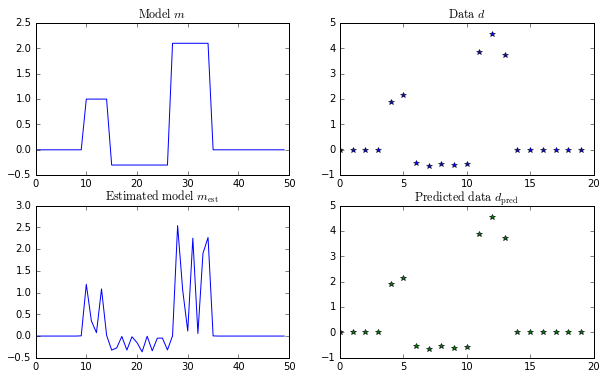

In [15]:
plot_all(m, d, m_est, d_pred)

## Solve with LAPACK

In [19]:
m_est = la.lstsq(G, d)[0]
d_pred = G.dot(m_est)

# Or, in Python 3.5
d_pred = G @ m_est

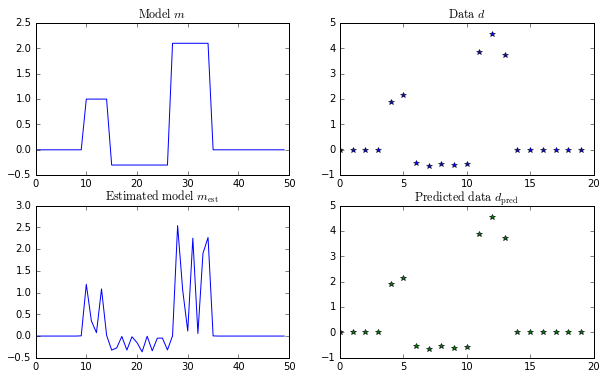

In [20]:
plot_all(m, d, m_est, d_pred)

## With noise: damped least squares

In [21]:
# Add noise.
dc = G.dot(m)  # Python < 3.5
dc = G @ m     # Python 3.5

# Add to the data.
s = 1
d = dc + s * np.random.random(dc.shape)

In [29]:
# Use the second form.
I = np.eye(N)
µ = 2.5  # We can use Unicode symbols in Python 3, just be careful
m_est = G.T.dot(la.inv(G.dot(G.T) + µ * I)).dot(d)
d_pred = G.dot(m_est)

# Or, in Python 3.5
m_est = G.T @ la.inv(G @ G.T + µ * I) @ d
d_pred = G @ m_est

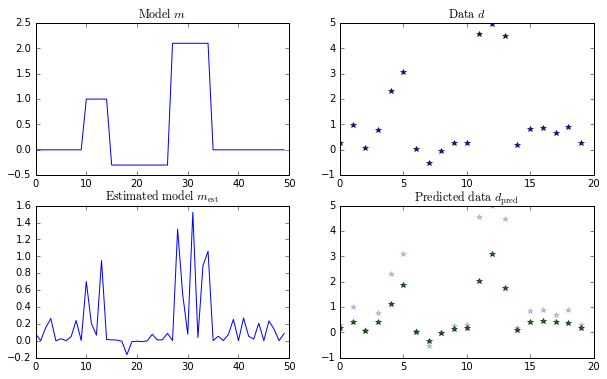

In [30]:
plot_all(m, d, m_est, d_pred)

## With noise: damped least squares with first derivative regularization

In [31]:
import scipy.linalg

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return scipy.linalg.toeplitz(col_1, row_1)

In [32]:
convmtx([1, -1], 5)

array([[ 1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.]])

In [33]:
W = convmtx([1,-1], M)[:,:-1]  # Skip last column

Now we solve:

$$ \hat{\mathbf{m}} = (\mathbf{G}^\mathrm{T} \mathbf{G} + \mu \mathbf{W}^\mathrm{T} \mathbf{W})^{-1} \mathbf{G}^\mathrm{T} \mathbf{d} \ \ $$

In [35]:
m_est = la.inv(G.T.dot(G) + µ*W.T.dot(W)).dot(G.T.dot(d))
d_pred = G.dot(m_est)

# Or, in Python 3.5
m_est = la.inv(G.T @ G + µ * W.T @ W) @ G.T @ d
d_pred = G @ m_est

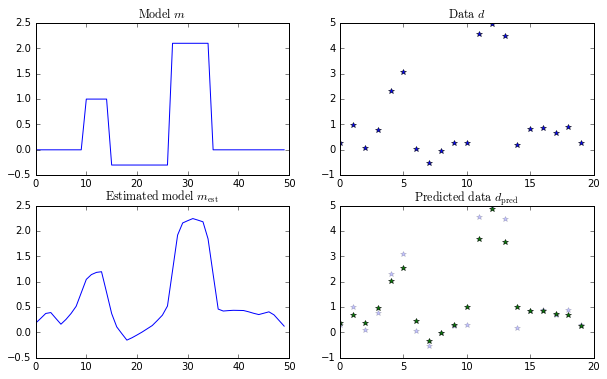

In [36]:
plot_all(m, d, m_est, d_pred)

## LU Factorization approach

It's not sensible to invert matrices all the time. 